# Train a mobilenet model using Tensorflow

This notebook walks you through the process of using transfer learning to train a pre-trained `mobilenet` to recognize different breeds of cats and dogs. We will be using the [Oxford IIIT Pets dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/) in this notebook.

It assumes that you have run through the `setup.ipynb` notebook to setup the workspace, datasets, and libraries that are used in this notebook. After you have run through the code in that notebook, you will have:

1. Created and started a Data Science Virtual Machine using a GPU-powered Azure VM size, e.g., NC6.
1. Downloaded and pre-processed the [Oxford IIIT Pets dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/)
1. Created an [Azure Machine Learning Workspace](https://docs.microsoft.com/en-us/azure/machine-learning/service/quickstart-get-started)
1. Created an [Azure Compute Cluster](https://docs.microsoft.com/en-us/azure/batch-ai/clusters)

All of these resources will be used by the code in this notebook.

## Examine the dataset

Let's look at the data in the dataset. The Oxford IIIT Pets dataset contains pictures of 37 different species of dogs and cats. All of that data lives in the ```images``` directory of this project. Let's begin by looking at the contents of this directory.

You can see that the name of each directory is the name of the breed. Within each directory is ~200 photos of that breed.

In [ ]:
!cd images

Let's look at some sample images for each breed. We're using some code in the ```image_helpers``` module to render and display thumbnails of each image using ```matplotlib```.

test


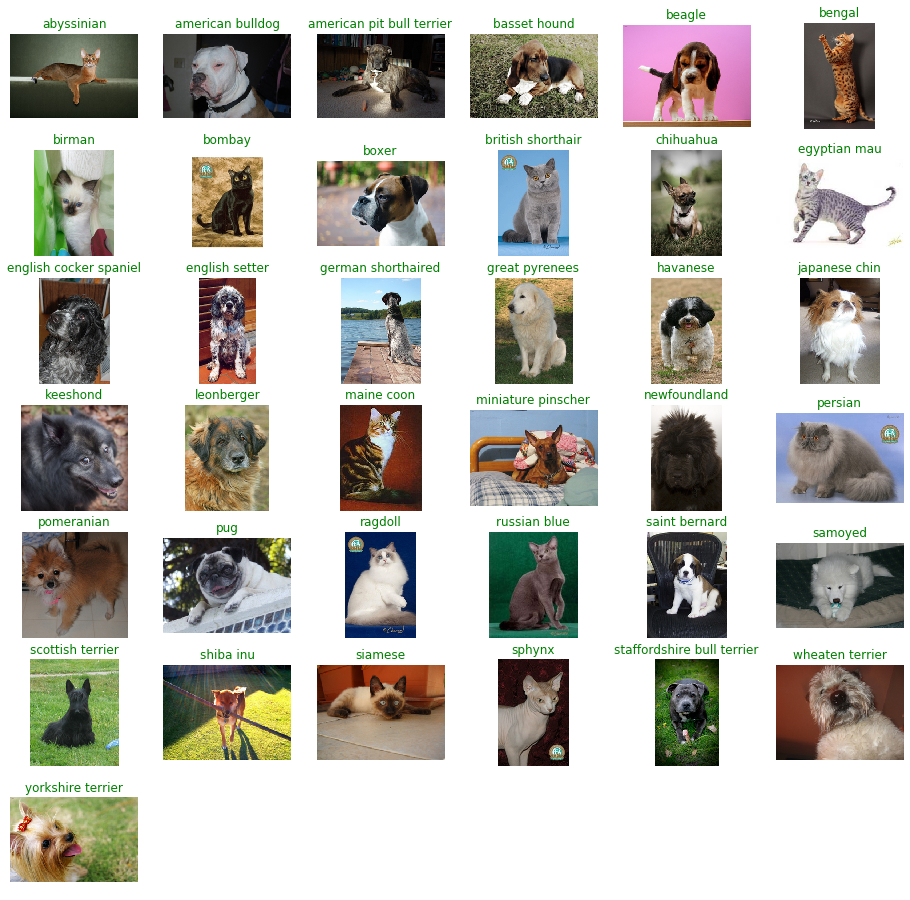

In [3]:
%matplotlib inline
from scripts.image_helpers import get_sample_images_for_each_species, plot_images_in_grid

print('test')
images_data = get_sample_images_for_each_species('images')
plot_images_in_grid(images_data, 6)

## Transfer learning using mobilenet and our pet images

Next, let's use transfer learning to retrain the final layer of the `mobilenet` model. We'll be using the images that we saw earlier to train this model. We'll do the training using the GPU powered Azure VM that's attached to this notebook. If you're using an `NC6` Azure VM Size, which has an NVidia K80 GPU card in it, the transfer learning should be complete in ~25s.

In [5]:
%%time
from scripts.retrain import train 

train(architecture='mobilenet_0.50_224', 
      image_dir='images', 
      output_dir='models', 
      bottleneck_dir='bottleneck',
      model_dir='model',
      learning_rate=0.00008, 
      training_steps=500,
      use_hyperdrive=False)

0 bottleneck files created.
INFO:tensorflow:1700 bottleneck files created.
INFO:tensorflow:1800 bottleneck files created.
INFO:tensorflow:1900 bottleneck files created.
INFO:tensorflow:2000 bottleneck files created.
INFO:tensorflow:2100 bottleneck files created.
INFO:tensorflow:2200 bottleneck files created.
INFO:tensorflow:2300 bottleneck files created.
INFO:tensorflow:2400 bottleneck files created.
INFO:tensorflow:2500 bottleneck files created.
INFO:tensorflow:2600 bottleneck files created.
INFO:tensorflow:2700 bottleneck files created.
INFO:tensorflow:2800 bottleneck files created.
INFO:tensorflow:2900 bottleneck files created.
INFO:tensorflow:3000 bottleneck files created.
INFO:tensorflow:3100 bottleneck files created.
INFO:tensorflow:3200 bottleneck files created.
INFO:tensorflow:3300 bottleneck files created.
INFO:tensorflow:3400 bottleneck files created.
INFO:tensorflow:3500 bottleneck files created.
INFO:tensorflow:3600 bottleneck files created.
INFO:tensorflow:3700 bottleneck 

The validation accuracy of this model isn't bad, with a **test accuracy of ~79%** using a learning rate of 0.00008. This is a pretty remarkable result, since the original model published in 2012 with the Oxford IIIT Pet Dataset only [achieved 59% accuracy](http://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf). 

Let's see if we can further improve the accuracy of this model using the Hyperdrive feature of Azure Machine Learning to explore different learning rates by doing many runs using an AML Compute cluster of GPU equipped VMs.

## Using HyperDrive to do hyper parameter optimization

Now that we have a model, the next step is to tune it for hyperdrive parameters. Hyperdrive works by copying a training script to each node in the cluster. We will be using an Azure ML `Datastore` that contains all of the images that we used locally in this DSVM. 

Get a reference to the ```Workspace``` and the ```Experiment``` that we will be using in this demo.

In [ ]:
from scripts.config import AML
from azureml.core import Workspace
from azureml.core import Experiment

ws = Workspace.get(name=AML.workspace_name, 
                   subscription_id=AML.subscription_id, 
                   resource_group=AML.resource_group) 

experiment = Experiment(ws, AML.experiment_name)
print(ws)
print(experiment)

Below is the training script that will be uploaded to each node in the Azure Compute cluster. You can see that it accepts two command-line parameters:

* `--datastore-dir` points to the directory that contains the Oxford IIIT Pets dataset that will be mapped onto each VM in the cluster
* `--learning-rate` is the learning rate that is passed into this node to try by the Hyperdrive daemon

In [4]:
%%writefile scripts/train.py

import argparse, os
import retrain as rt

parser = argparse.ArgumentParser()
parser.add_argument('--datastore-dir', type=str, dest='datastore_dir', help='datastore dir mounting point')
parser.add_argument('--learning-rate', type=float, dest='learning_rate', default=0.01, help='learning rate')
args = parser.parse_args()

images_dir = os.path.join(args.datastore_dir, 'images')
bottleneck_dir = os.path.join(args.datastore_dir, 'bottleneck')
model_dir = os.path.join(args.datastore_dir, 'model')
output_dir = 'outputs'

rt.train(architecture='mobilenet_0.50_224', 
         image_dir=images_dir,
         output_dir=output_dir,
         bottleneck_dir=bottleneck_dir,
         model_dir=model_dir,
         learning_rate=args.learning_rate,
         training_steps=2000,
         use_hyperdrive=True)

Overwriting scripts/train.py


## Submit the job to Hyperdrive

Now let's create and submit a Hyperdrive job. There are two key things to point out here:

1. We are doing a random sampling of the learning rate, varying it from 10E-15 to 10E-3, using a logarithmic random number generator.
1. We are point to a ```Datastore``` that we have configured earlier with the Oxford IIIT training dataset passed in by reference to each node on the compute store.
1. We are passing the ```train.py``` file that we wrote out earlier to each compute node on the AML Compute cluster.
1. The training code writes out ```validation_accuracy``` to a logfile that is read by the Hyperdrive daemon to determine whether to prematurely terminate some runs if they are not within 15% of the best run to date.


Run the next cell to kick off a hyperdrive run. A full run takes ~22 minutes to complete.Run the cell after that to look at data that came from an older run.

In [ ]:
from azureml.train.dnn import TensorFlow
from azureml.train.hyperdrive import RandomParameterSampling, BanditPolicy, HyperDriveRunConfig, PrimaryMetricGoal
from azureml.train.hyperdrive import loguniform, uniform

cluster = ws.compute_targets[AML.compute_name]

script_params={
    '--datastore-dir': ws.get_default_datastore().as_mount(),
}

tf_estimator = TensorFlow(source_directory='scripts',
                          compute_target=cluster,
                          entry_script='train.py',
                          script_params=script_params,
                          use_gpu=True)

ps = RandomParameterSampling(
    {
        '--learning-rate': loguniform(-15, -3)
    }
)

early_termination_policy = BanditPolicy(slack_factor = 0.15, evaluation_interval=2)

hyperdrive_run_config = HyperDriveRunConfig(estimator = tf_estimator, 
                                            hyperparameter_sampling = ps, 
                                            policy = early_termination_policy,
                                            primary_metric_name = "validation_accuracy",
                                            primary_metric_goal = PrimaryMetricGoal.MAXIMIZE,
                                            max_total_runs = 10,
                                            max_concurrent_runs = 4)

hd_run = experiment.submit(hyperdrive_run_config)
hd_run_id = hd_run.id
hd_run_id

Let's look at the progress of the HyperDrive run using the Azure Machine Learning Jupyter widget:

In [ ]:
from azureml.core import Run
from azureml.widgets import RunDetails

RunDetails(Run(experiment, hd_run_id)).show()

Let's look at a completed HyperDrive run so we can see the results

In [ ]:
hd_run_id = 'jemew-experiment_1574808052965294'

Show progress using the AML Widget. If we are looking at `ConnectExperiment_1542152717287`, the best run from the list below is number 233, `ConnectExperiment_1542152717287_15`. It has a `final_accuracy` of 90%, which uses a test dataset that was not used for either training or validation.

In [ ]:
from azureml.core import Run
from azureml.widgets import RunDetails

RunDetails(Run(experiment, hd_run_id)).show()

## Register the best run


In [ ]:
from azureml.core import Run

best_run = Run(experiment, run_id='jemew-experiment_1574808052965294')
model = best_run.register_model(model_name='pet-detector', model_path='outputs')
best_run

## Training complete - let's turn this into production code

Jupyter notebooks are great for experimentation and keeping track of what you have tried. Now that we have a model that we're happy with, it's time to write some code so that we can reproducibly train, optimize and deploy models in the future. We'll do the next steps using Visual Studio Code.

In [ ]:
print("hello")

In [ ]:
bla